In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path

#### At first, let's load the district shape file as a GeoDataFrame

In [2]:
dis_shp = Path(r"C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\dem\germany_Districts_level_3\germany_Districts_level_3.shp")
result_path = Path(r"C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\results")

In [3]:
districts = gpd.read_file(dis_shp)
districts

shape3 shapeiso                  shapeid shapegroup  \
0  Stuttgart, Stadtkreis     None  24449704B93822824114115        DEU   
1              Boblingen     None  24449704B72388855136116        DEU   
2              Esslingen     None  24449704B78170061662970        DEU   
3              Goppingen     None  24449704B15733768689180        DEU   
4            Ludwigsburg     None   24449704B8810282891784        DEU   
5        Rems-Murr-Kreis     None  24449704B27916730634453        DEU   
6   Heilbronn, Landkreis     None  24449704B87056539053422        DEU   
7         Hohenlohekreis     None  24449704B58640950424852        DEU   
8        Schwabisch Hall     None  24449704B74971377673451        DEU   
9      Main-Tauber-Kreis     None  24449704B27200634903079        DEU   

  shapetype  gid     shape2             shape1   shape0  \
0      ADM3    1  Stuttgart  Baden-Wurttemberg  germany   
1      ADM3    2  Stuttgart  Baden-Wurttemberg  germany   
2      ADM3    3  Stuttgart  Baden-Wurttemberg  germany   
3      ADM3    4  Stuttgart  Baden-Wurttemberg  germany   
4      ADM3    5  Stuttgart  Baden-Wurttemberg  germany   
5      ADM3    6  Stuttgart  Baden-Wurttemberg  germany   
6      ADM3    8  Stuttgart  Baden-Wurttemberg  germany   
7      ADM3    9  Stuttgart  Baden-Wurttemberg  germany   
8      ADM3   10  Stuttgart  Baden-Wurttemberg  germany   
9      ADM3   11  Stuttgart  Baden-Wurttemberg  germany   

                                            geometry  
0  POLYGON ((9.24417 48.84701, 9.24291 48.84547, ...  
1  POLYGON ((9.068 48.75658, 9.06416 48.75487, 9....  
2  MULTIPOLYGON (((9.10472 48.70908, 9.10705 48.7...  
3  POLYGON ((9.58248 48.53915, 9.58093 48.54082, ...  
4  MULTIPOLYGON (((9.24417 48.84701, 9.24223 48.8...  
5  POLYGON ((9.31365 48.77448, 9.31463 48.7756, 9...  
6  POLYGON ((9.39939 49.03817, 9.39756 49.0376, 9...  
7  POLYGON ((9.52749 49.10855, 9.52665 49.11072, ...  
8  POLYGON ((9.69331 48.96402, 9.69088 48.96604, ...  
9  POLYGON ((9.85556 49.36837, 9.85247 49.36804, ...

#### Now, let's extract our area of interest "Esslingen", located at the Stuttgart district of Germany, as a different GeoDataFrame

shape3 shapeiso                  shapeid shapegroup shapetype  gid  \
2  Esslingen     None  24449704B78170061662970        DEU      ADM3    3   

      shape2             shape1   shape0  \
2  Stuttgart  Baden-Wurttemberg  germany   

                                            geometry  
2  MULTIPOLYGON (((9.10472 48.70908, 9.10705 48.7...

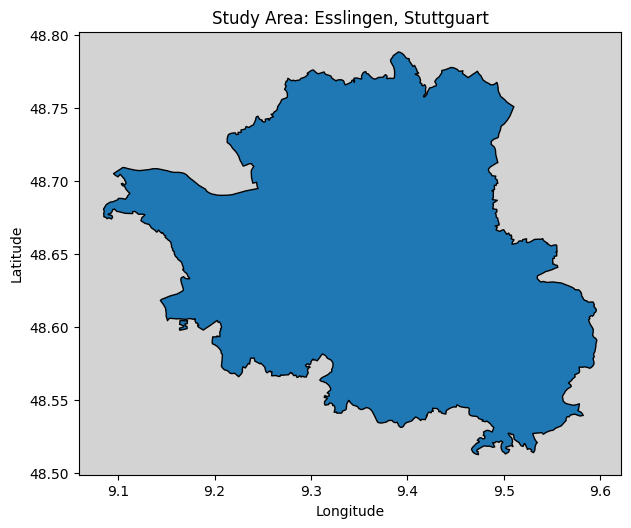

In [4]:
esslingen_df = districts[districts['shape3'] == 'Esslingen']
display(esslingen_df)

#visualize the study area
fig, ax = plt.subplots(figsize=(7, 7))
esslingen_df.plot(ax=ax, edgecolor='black')
ax.set_title('Study Area: Esslingen, Stuttguart')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_facecolor('lightgray')

fig.savefig(result_path/'study_area_vector.jpg', dpi=300)

#### Now load the downloaded raster tiles, include them in a dictionary and have a look on them

In [5]:
dem_path = Path(r"C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\dem\esslingen_srtm_bulk")

In [6]:
tile1 = dem_path/'tile1.tif'
tile2 = dem_path/'tile2.tif'
tile3 = dem_path/'tile3.tif'
tile4 = dem_path/'tile4.tif'

input_rasters = {
    'tile1': tile1,
    'tile2': tile2,
    'tile3': tile3,
    'tile4': tile4
}

In [7]:
from rasterio.plot import show

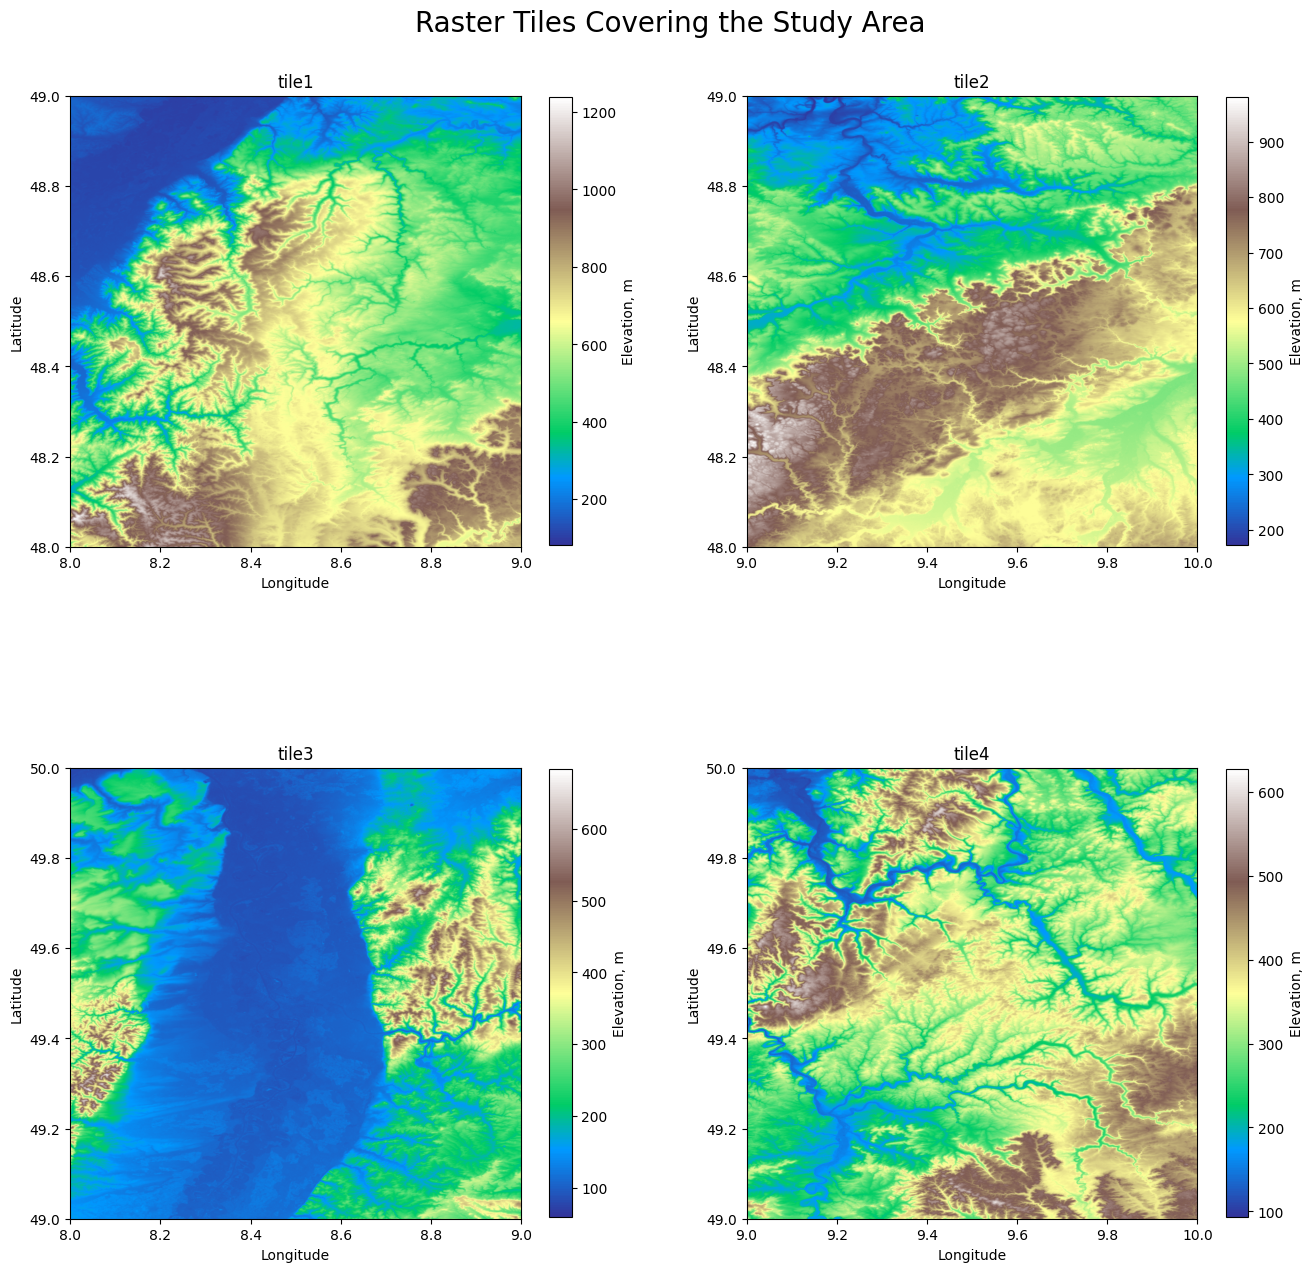

In [8]:
meta = {}
src_to_mosaic = []
fig, axes = plt.subplots(2, 2, figsize=(16,16))
for i, (tile, file) in enumerate(input_rasters.items()):
    with rasterio.open(file) as src:

        data = src.read(1)
        vmax, vmin = data.max(), data.min()
        meta[tile] = src.meta
        src_to_mosaic.append(src)
        
        ax = axes.flat[i]
        show(src, ax=ax, vmax=vmax, vmin=vmin, cmap='terrain')
        ax.set_title(tile)
        ax.set_facecolor('lightgrey')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        plt.colorbar(ax.images[0], ax=ax, label='Elevation, m', shrink=0.8)
fig.suptitle('Raster Tiles Covering the Study Area', fontsize=20, y=0.90)
fig.savefig(result_path/'all_tiles.jpg')


#### As our study area is covered by 4 seperate raster tiles, at this point, let's merge the them and get a single DEM tile

In [9]:
from rasterio.merge import merge

In [10]:
#listiling the datasets to mosaic
src_to_mosaic = [rasterio.open(file) for (tile, file) in input_rasters.items()]

#merging
mosaic, out_transform = merge(src_to_mosaic)

#preparing metadata of the merged raster
out_meta = src_to_mosaic[0].meta.copy()
out_meta.update({
    'height': mosaic.shape[1],
    'width': mosaic.shape[2],
    'transform': out_transform,
    'driver': 'GTiff'
})

#writing the merged dem as a new raster file
outfile = dem_path/'merged_dem.tif'

with rasterio.open(outfile, 'w', **out_meta) as dest:
    dest.write(mosaic)

for src in src_to_mosaic:
    src.close()

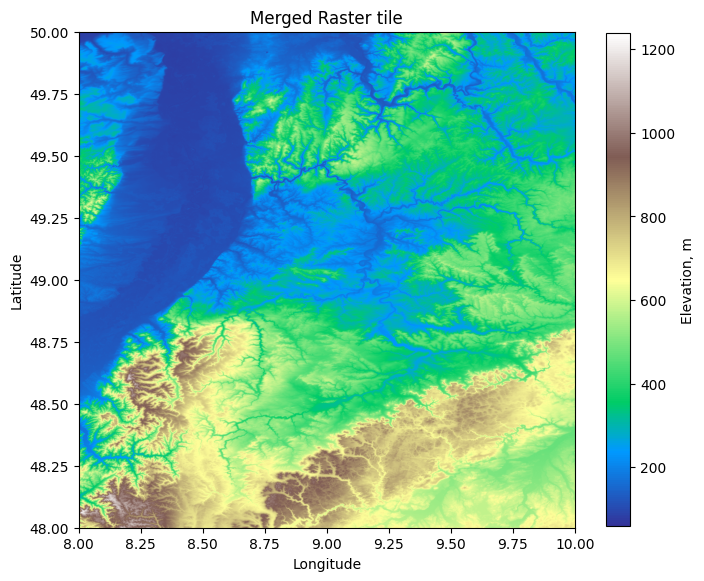

In [11]:
#visualize the merged raster
merged_dem = dem_path/'merged_dem.tif'

fig, ax = plt.subplots(figsize=(8, 8))
with rasterio.open(merged_dem) as src:
    data = src.read(1)
    vmax = data.max()
    vmin = data.min()
    merged_dem_meta = src.meta
    
    show(src, ax=ax, vmax=vmax, vmin=vmin, cmap='terrain')
    ax.set_title('Merged Raster tile')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(ax.images[0], ax=ax, shrink=0.8, label='Elevation, m')
fig.savefig(result_path/'merged_tiles.jpg')

#### Let's clip the merged raster tile to the extend of our study area using the study area vector

In [12]:
#the raster and vector needs to be in the same crs
print(f"The raster and the vector have same crs: {merged_dem_meta['crs'] == esslingen_df.crs}")
print(f"Raster's crs: {merged_dem_meta['crs']}")
print(f"Vector's crs: {esslingen_df.crs}")

The raster and the vector have same crs: True
Raster's crs: EPSG:4326
Vector's crs: EPSG:4326


In [13]:
from rasterio.mask import mask

In [14]:
#clip the raster
with rasterio.open(merged_dem) as src:
    out_array, out_transform = mask(src, esslingen_df.geometry, crop=True)
    out_meta = src.meta.copy()

#update metadata for writing new clipped raster
out_meta.update({
    'height': out_array.shape[1],
    'width': out_array.shape[2],
    'transform': out_transform, 
})

#write/save the new clipped raster
clipped_dem = dem_path/'clipped_dem.tif'
with rasterio.open(clipped_dem, 'w', **out_meta) as dest:
    dest.write(out_array)

No data value: -32767.0
Maximum Elevation: 839.0 m
Minimum Elevation: 224.0 m


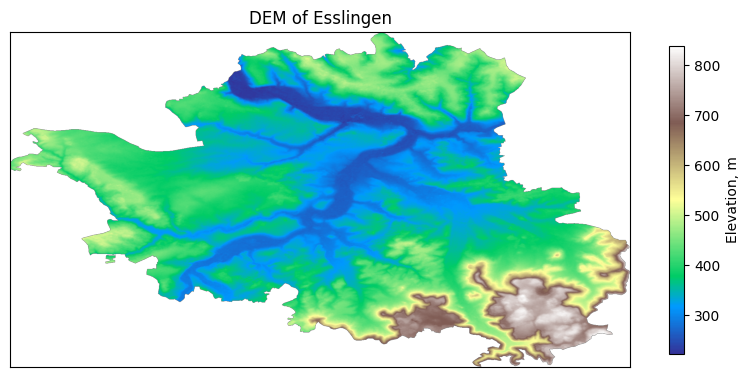

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
with rasterio.open(clipped_dem) as src:
    data = src.read(1).astype('float32')
    nodata = src.nodata
    if nodata is not None:
        data[data==nodata] = np.nan
    vmax = np.nanmax(data)
    vmin = np.nanmin(data)
    print(f"No data value: {nodata}")
    print(f"Maximum Elevation: {vmax} m")
    print(f"Minimum Elevation: {vmin} m")
    show(src, ax=ax, cmap='terrain', vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('DEM of Esslingen')
    plt.colorbar(ax.images[0], ax=ax, shrink=0.5, label='Elevation, m')
fig.savefig(result_path/'clipped_dem.jpg')

#### For further analysis and watershed delineation we will use the WhiteboxTools, a dediated python package for hydrological operations. 

In [16]:
import whitebox
wbt = whitebox.WhiteboxTools()
wbt.set_working_dir(dem_path)

#### Calculate Slope, Aspect, and Hillshade using WhiteboxTools

In [17]:
#slope
wbt.slope(
    dem='clipped_dem.tif',
    output='slope.tif'
)

#aspect
wbt.aspect(
    dem='clipped_dem.tif',
    output='aspect.tif')

#hillshade
wbt.hillshade(
    dem='clipped_dem.tif',
    azimuth=315.0,
    altitude=45.0,
    output='hillshade.tif')

.\whitebox_tools.exe --run="Slope" --wd="C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\dem\esslingen_srtm_bulk" --dem='clipped_dem.tif' --output='slope.tif' --units=degrees -v --compress_rasters=False

****************************
* Welcome to Slope         *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%

0

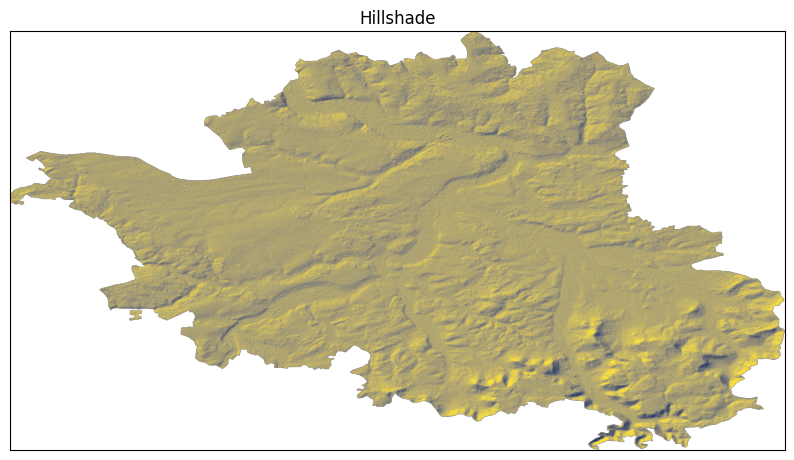

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))
with rasterio.open(dem_path/'hillshade.tif') as src:
    data = src.read(1).astype('float32')
    nodata = src.nodata if src.nodata is not None else -32767  # fallback if missing

    # Force masking
    mask = np.isclose(data, nodata, atol=1)  # tight tolerance
    data = np.ma.array(data, mask=mask)

    extent = [
            src.bounds.left,
            src.bounds.right,
            src.bounds.bottom,
            src.bounds.top
        ]

    img = ax.imshow(data, extent=extent, cmap='cividis', origin='upper')
    ax.set_title("Hillshade")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    

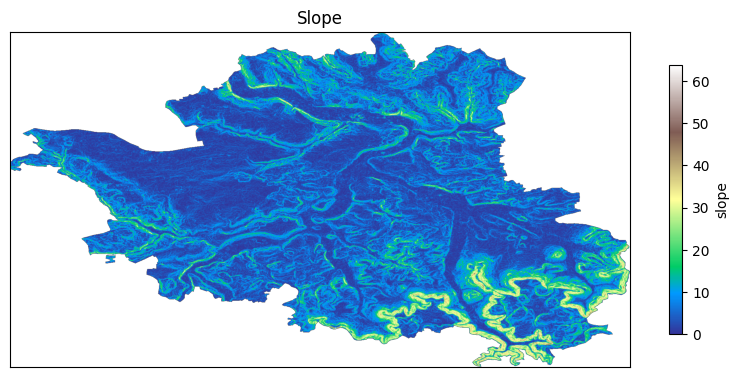

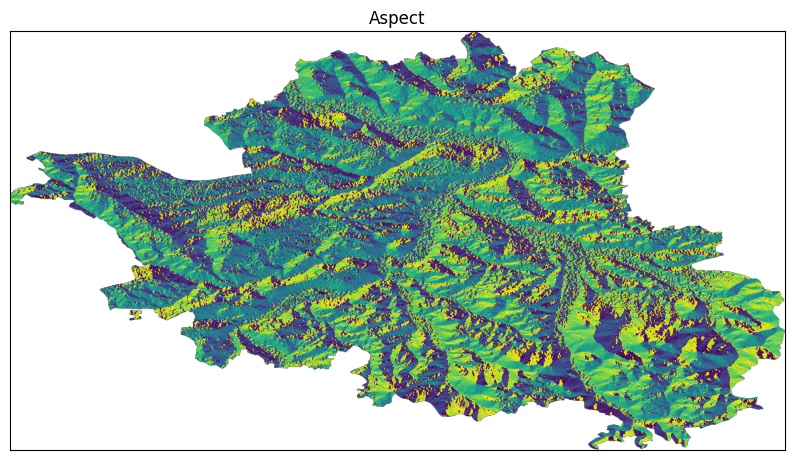

In [19]:
rasters = list(dem_path.glob('*slope.tif')) + \
          list(dem_path.glob('*aspect.tif'))


for i, file in enumerate(rasters):
    key = file.stem
    title = key.title()

    fig, ax = plt.subplots(figsize=(10, 7))
    with rasterio.open(file) as src:
        if i == 1:
            show(src, ax=ax)
        else:
            show(src, ax=ax, cmap='terrain')
            plt.colorbar(ax.images[0], ax=ax, label=key, shrink=0.5)
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        fig.savefig(result_path/f"{key}.jpg")
        

#### Preparing for watershed for delineation: fill the sink, calculate flow direction and flow accumulation matrices

In [20]:
#filling the sink
wbt.fill_depressions(
    dem='clipped_dem.tif',
    output='sink_filled_dem.tif')

#Calculating flow path
wbt.d8_pointer(
    dem='sink_filled_dem.tif',
    output='flow_direction.tif')

#calculate flow accumulation
wbt.fd8_flow_accumulation(
    dem='sink_filled_dem.tif',
    output='flow_accumulation.tif')

.\whitebox_tools.exe --run="FillDepressions" --wd="C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\dem\esslingen_srtm_bulk" --dem='clipped_dem.tif' --output='sink_filled_dem.tif' --fix_flats -v --compress_rasters=False

******************************
* Welcome to FillDepressions *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Reading data...
Finding pit cells: 25%
Finding pit cells: 50%
Finding pit cells: 75%
Finding pit cells: 100%
Filling depressions: 0%
Filling depressions: 1%
Filling depressions: 2%
Filling depressions: 3%
Filling depressions: 4%
Filling depressions: 5%
Filling depressions: 6%
Filling depressions: 7%
Filling depressions: 8%
Filling depressions: 9%
Filling depressions: 10%
Filling depressions: 11%
Filling depressions: 12%
Filling depressions: 13%
Filling depressions: 14%
Filling depressions: 15%
Filling depressions: 16%
Filling depressions: 17%
Filling depressi

0

Visualizing sink_filled_dem
Visualizing flow_direction
Visualizing flow_accumulation


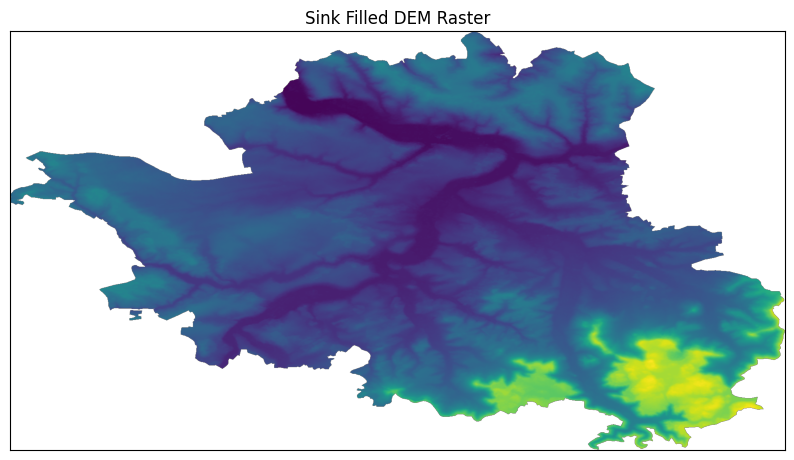

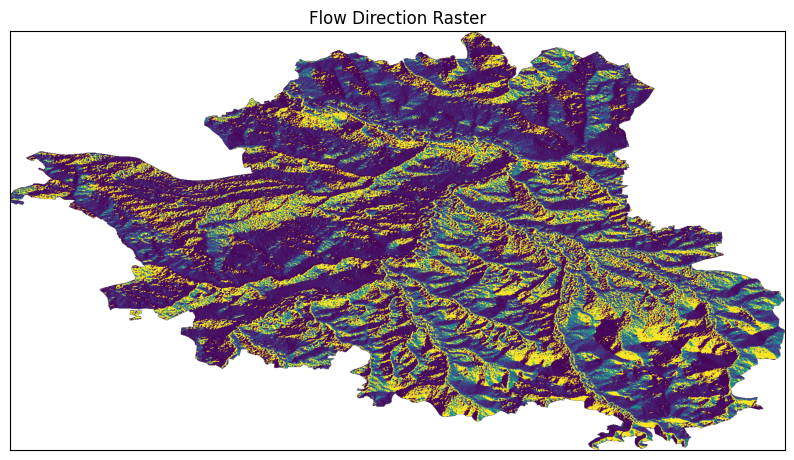

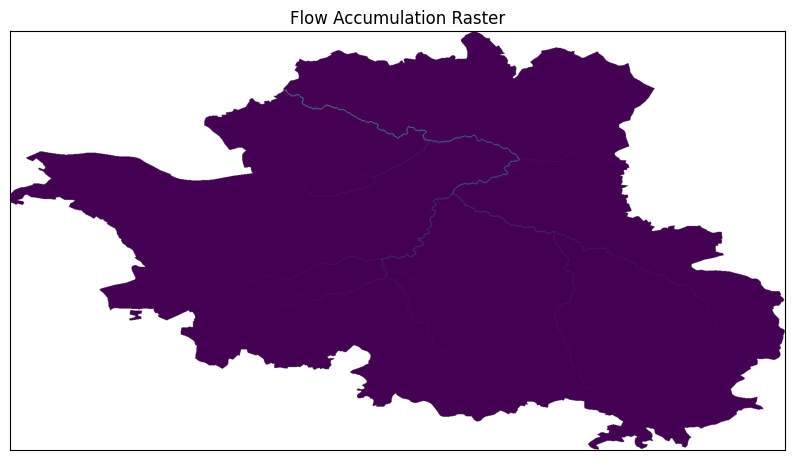

In [21]:
rasters = list(dem_path.glob('*filled_dem.tif')) + \
            list(dem_path.glob('*direction.tif')) + \
            list(dem_path.glob('*accumulation.tif'))

for file in rasters:
    print(f"Visualizing {file.stem}")

    key = file.stem
    title = key.replace('_', ' ').title().replace('Dem', 'DEM') + ' Raster'

    try:
        fig, ax = plt.subplots(figsize=(10, 7))
        with rasterio.open(file) as src:
            data = src.read(1)
            show(src, ax=ax)
            ax.set_title(title)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel('')
            ax.set_ylabel('')
            fig.savefig(result_path/f"{key}_raster.jpg")

    except exception as e:
        print(f"Error processing {file.name}: {e}")
          

#### From the flow accumulation raster, extract the streams 

In [22]:
wbt.extract_streams(
    flow_accum='flow_accumulation.tif',
    output='streams.tif',
    threshold=15)

.\whitebox_tools.exe --run="ExtractStreams" --wd="C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\dem\esslingen_srtm_bulk" --flow_accum='flow_accumulation.tif' --output='streams.tif' --threshold='15' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

0

#### How does the stream network looks?

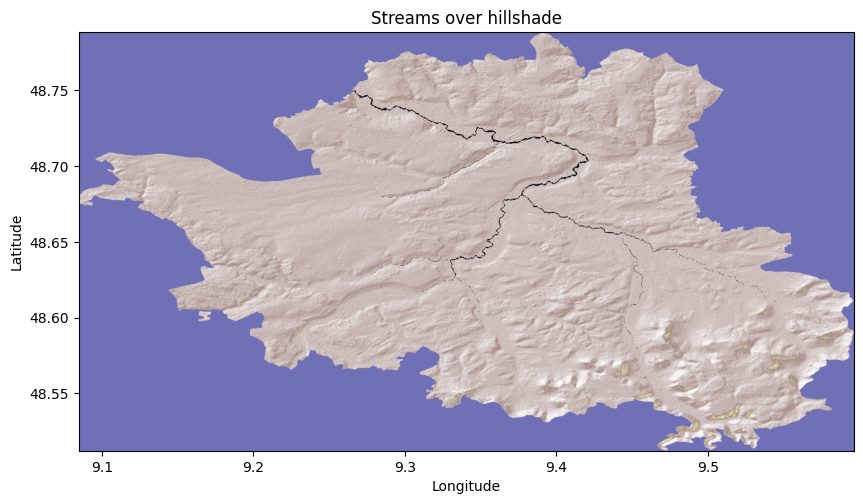

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
with rasterio.open(dem_path/'hillshade.tif') as hill:
    show(hill, ax=ax, cmap='terrain', alpha=0.7)
with rasterio.open(dem_path/'streams.tif') as strms:
    show(strms, ax=ax, cmap='inferno')
    ax.set_title("Streams over hillshade")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
#fig.savefig(result_path/'streams_over_hillshade.jpg', dpi=300)

#### Load the outlet vector prepared in QGIS

In [24]:
shape_path = Path(r"C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\vectors")

In [25]:
wbt.watershed(
    d8_pntr=dem_path/'flow_direction.tif',
    pour_pts=shape_path/'pour_points_qgis.shp',
    output='watershed.tif',
    esri_pntr=False)

.\whitebox_tools.exe --run="Watershed" --wd="C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\dem\esslingen_srtm_bulk" --d8_pntr='C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\dem\esslingen_srtm_bulk\flow_direction.tif' --pour_pts='C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\vectors\pour_points_qgis.shp' --output='watershed.tif' -v --compress_rasters=False

****************************
* Welcome to Watershed     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Locating pour points: 0%
Locating pour points: 50%
Locating pour points: 100%
Initializing: 0%
Initializing: 1%
Initializing: 2%
Initializing: 3%
Initializing: 4%
Initializing: 5%
Initializing: 6%
Initializing: 7%
Initializing: 8%
Initializing: 9%
Initializing: 10%
Initializing: 11%
Initializi

0

#### How the delineated subbasins look

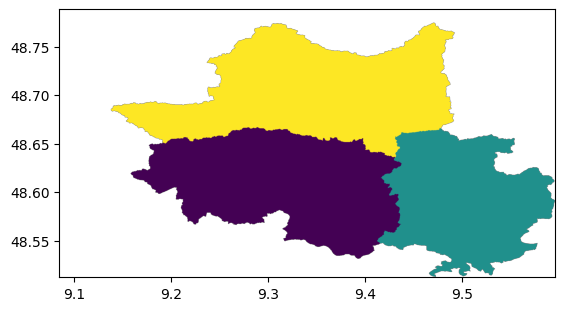

In [26]:
with rasterio.open(dem_path/'watershed.tif') as src:
    show(src)

#### Vectorization of the streams and Subbasins

In [27]:
from rasterio import features
from shapely.geometry import shape

In [28]:
###Vectorization using manual method

#open the raster
with rasterio.open(dem_path/'watershed.tif') as src:
    raster = src.read(1)
    nodata = src.nodata
    transform = src.transform
    crs = src.crs
    
#Handle no data
if nodata is not None:
    raster = np.where(raster==nodata, np.nan, raster)

#create mask
mask = (~np.isnan(raster)) & (raster !=0)

#extract shape and value
raw_shapes = features.shapes(raster, mask=mask, transform=transform)

#make dictionary with shape and value for geodataframe
records = []
for poly, value in raw_shapes:
    record = {
        'geometry': shape(poly),
        'subbsn_ID': value
    }
    records.append(record)

#create geodataframe, write the shape file
watershed_gdf = gpd.GeoDataFrame(records, crs=crs)
watershed_gdf.to_file(shape_path/'watersheds.shp')

In [29]:
watershed_gdf

geometry  subbsn_ID
0  POLYGON ((9.47153 48.77458, 9.47153 48.77431, ...        3.0
1  POLYGON ((9.27958 48.66653, 9.27958 48.66625, ...        1.0
2  POLYGON ((9.47764 48.66569, 9.47764 48.66542, ...        2.0

In [30]:
### vectorization using whitebox function

wbt.raster_streams_to_vector(
    streams=dem_path/'streams.tif',
    d8_pntr=dem_path/'flow_direction.tif',
    output=shape_path/'streams.shp')

.\whitebox_tools.exe --run="RasterStreamsToVector" --wd="C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\dem\esslingen_srtm_bulk" --streams='C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\dem\esslingen_srtm_bulk\streams.tif' --d8_pntr='C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\dem\esslingen_srtm_bulk\flow_direction.tif' --output='C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month1_watershed_delineation_terrain_analysis\vectors\streams.shp' -v --compress_rasters=False

************************************
* Welcome to RasterStreamsToVector *
* Powered by WhiteboxTools         *
* www.whiteboxgeo.com              *
************************************
Reading pointer data...
Reading streams data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%

0

In [31]:
streams_gdf = gpd.read_file(shape_path/'streams.shp')

#### Lest visualize the delineated subbasin 

In [32]:
import matplotlib.lines as mlines

In [33]:
outlets_gdf = gpd.read_file(shape_path/'pour_points_qgis.shp')

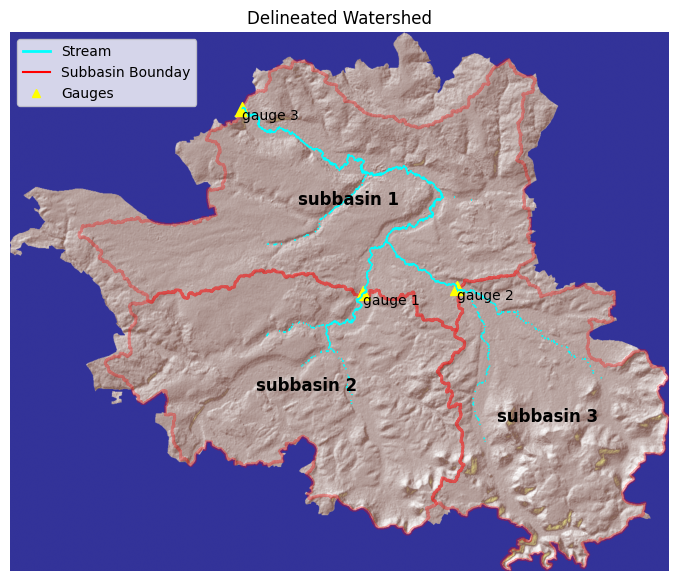

In [34]:
#plot everything
fig, ax = plt.subplots(figsize=(10, 7))
with rasterio.open(dem_path/'hillshade.tif') as hill:
    show(hill, ax=ax, cmap='terrain')
watershed_gdf.plot(ax=ax, linewidth=2, alpha=0.3, facecolor='none', edgecolor='red')
streams_gdf.plot(ax=ax, color='cyan', linewidth=1.2)
outlets_gdf.plot(ax=ax, color='yellow', marker='^', markersize=100)

#put the labels
for index, row in watershed_gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, f"subbasin {index+1}",
           fontsize=12, fontweight='bold', color='black',
           ha='center', va='center')
    
for index, row in outlets_gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, f"gauge {index+1}",
            fontsize=10, color='black',
            ha='left', va='top')

#put the legends
stream_line = mlines.Line2D([], [], color='cyan', linewidth=2, label='Stream')
subbasin_boundary = mlines.Line2D([], [], color='red', label='Subbasin Bounday')
point_marker = mlines.Line2D([], [], color='yellow', marker='^', label='Gauges', linestyle='none')
ax.legend(handles=[stream_line, subbasin_boundary, point_marker], loc='upper left')


#Title and axis title
ax.set_title("Delineated Watershed")
ax.set_axis_off()
    

fig.savefig(result_path/'delineated_watershed.jpg', dpi=300)